<a href="https://colab.research.google.com/github/MrBadonzi/-RL-Project-A3C-Mario/blob/main/Camouflaged_Object_Segmentation_with_Distraction_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import os
import glob
import numpy as np
from PIL import Image
from pathlib import Path
import pathlib
import imageio
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb


In [2]:
!pip install torch==1.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.
torchvision 0.15.2+cu118 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.


In [3]:
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip TestDataset

In [5]:
!unzip /content/drive/MyDrive/TestDataset.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: TestDataset/COD10K/Imgs/COD10K-CAM-1-Aquatic-13-Pipefish-597.jpg  
  inflating: TestDataset/COD10K/Imgs/COD10K-CAM-1-Aquatic-13-Pipefish-591.jpg  
  inflating: TestDataset/COD10K/Imgs/COD10K-CAM-1-Aquatic-13-Pipefish-590.jpg  
  inflating: TestDataset/COD10K/Imgs/COD10K-CAM-1-Aquatic-13-Pipefish-588.jpg  
  inflating: TestDataset/COD10K/Imgs/COD10K-CAM-1-Aquatic-13-Pipefish-585.jpg  
  inflating: TestDataset/COD10K/Imgs/COD10K-CAM-1-Aquatic-13-Pipefish-583.jpg  
  inflating: TestDataset/COD10K/Imgs/COD10K-CAM-1-Aquatic-13-Pipefish-582.jpg  
  inflating: TestDataset/COD10K/Imgs/COD10K-CAM-1-Aquatic-13-Pipefish-580.jpg  
  inflating: TestDataset/COD10K/Imgs/COD10K-CAM-1-Aquatic-13-Pipefish-579.jpg  
  inflating: TestDataset/COD10K/Imgs/COD10K-CAM-1-Aquatic-13-Pipefish-577.jpg  
  inflating: TestDataset/COD10K/Imgs/COD10K-CAM-1-Aquatic-13-Pipefish-576.jpg  
  inflating: TestDataset/COD10K/Imgs/COD10K-CAM-1-Aquatic-13-Pipefish-

Unzip Train Dataset

In [6]:
!unzip /content/drive/MyDrive/TrainDataset.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: TrainDataset/GT/camourflage_00199.png  
  inflating: TrainDataset/GT/camourflage_00198.png  
  inflating: TrainDataset/GT/camourflage_00195.png  
  inflating: TrainDataset/GT/camourflage_00194.png  
  inflating: TrainDataset/GT/camourflage_00193.png  
  inflating: TrainDataset/GT/camourflage_00192.png  
  inflating: TrainDataset/GT/camourflage_00191.png  
  inflating: TrainDataset/GT/camourflage_00190.png  
  inflating: TrainDataset/GT/camourflage_00189.png  
  inflating: TrainDataset/GT/camourflage_00187.png  
  inflating: TrainDataset/GT/camourflage_00185.png  
  inflating: TrainDataset/GT/camourflage_00184.png  
  inflating: TrainDataset/GT/camourflage_00182.png  
  inflating: TrainDataset/GT/camourflage_00181.png  
  inflating: TrainDataset/GT/camourflage_00180.png  
  inflating: TrainDataset/GT/camourflage_00179.png  
  inflating: TrainDataset/GT/camourflage_00178.png  
  inflating: TrainDataset/GT/camourflage_00177.pn

# Prepare Dataset

In [7]:
import random

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask):
        assert img.size == mask.size
        for t in self.transforms:
            img, mask = t(img, mask)
        return img, mask

class RandomHorizontallyFlip(object):
    def __call__(self, img, mask):
        if random.random() < 0.5:
            return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
        return img, mask

class Resize(object):
    def __init__(self, size):
        self.size = tuple(reversed(size))  # size: (h, w)  PIL: (w, h)

    def __call__(self, img, mask):
        assert img.size == mask.size
        return img.resize(self.size, Image.BILINEAR), mask.resize(self.size, Image.NEAREST)

Make Dataset

In [8]:
def make_dataset(root):
    image_path = os.path.join(root, 'Imgs')
    mask_path = os.path.join(root, 'GT')
    img_list = [os.path.splitext(f)[0] for f in os.listdir(image_path) if f.endswith('.jpg')]
    return [(os.path.join(image_path, img_name + '.jpg'), os.path.join(mask_path, img_name + '.png')) for img_name in img_list]

class ImageFolder(data.Dataset):
    # image and gt should be in the same folder and have same filename except extended name (jpg and png respectively)
    def __init__(self, root, joint_transform=None, transform=None, target_transform=None):
        self.root = root
        self.imgs = make_dataset(root)
        self.joint_transform = joint_transform
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        img_path, gt_path = self.imgs[index]
        img = Image.open(img_path).convert('RGB')
        target = Image.open(gt_path).convert('L')
        if self.joint_transform is not None:
            img, target = self.joint_transform(img, target)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [9]:
args = {
    'epoch_num': 45,
    'train_batch_size': 16,
    'last_epoch': 0,
    'lr': 1e-3,
    'lr_decay': 0.9,
    'weight_decay': 5e-4,
    'momentum': 0.9,
    'snapshot': '',
    'scale': 416,
    'save_point': [1,10,20,30,40],
    'poly_train': True,
    'optimizer': 'SGD',
}

Transform and create the Dataset

In [10]:
# Transform Data.
joint_transform = Compose([
    RandomHorizontallyFlip(),
    Resize((args['scale'], args['scale']))
])
img_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
target_transform = transforms.ToTensor()




In [11]:
# Prepare Data Set.
train_set = ImageFolder('/content/TrainDataset', joint_transform, img_transform, target_transform)
print("Train set: {}".format(train_set.__len__()))
train_loader = DataLoader(train_set, batch_size=args['train_batch_size'], num_workers=16, shuffle=True)

total_epoch = args['epoch_num'] * len(train_loader)

Train set: 4040


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


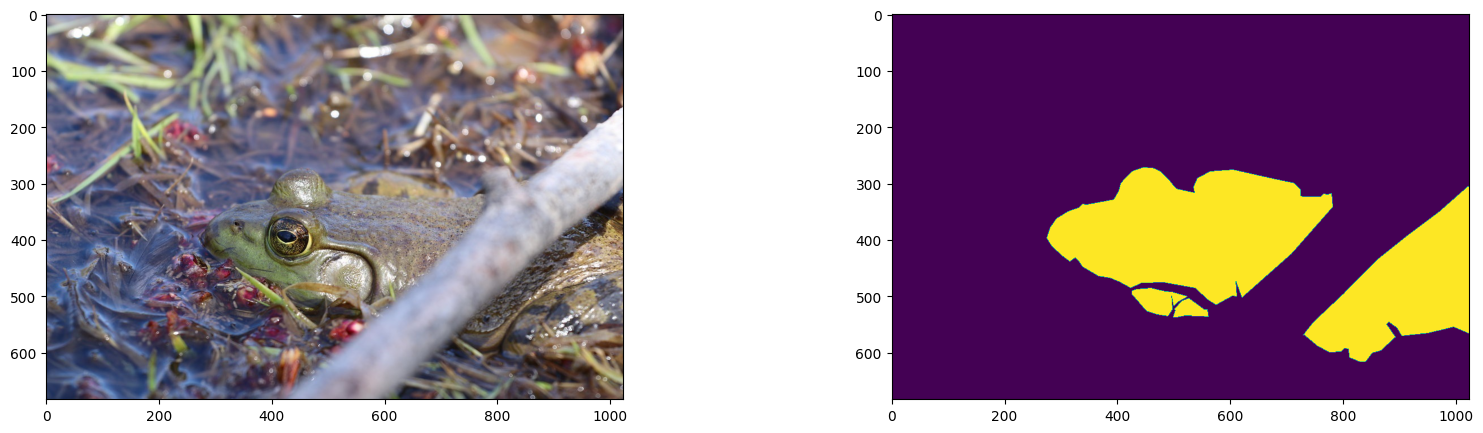

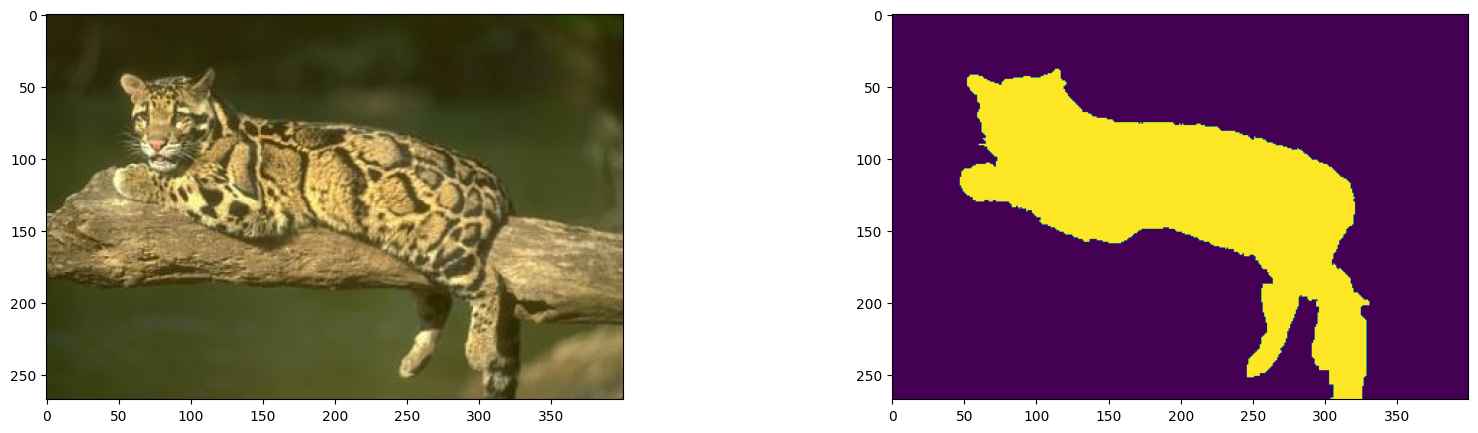

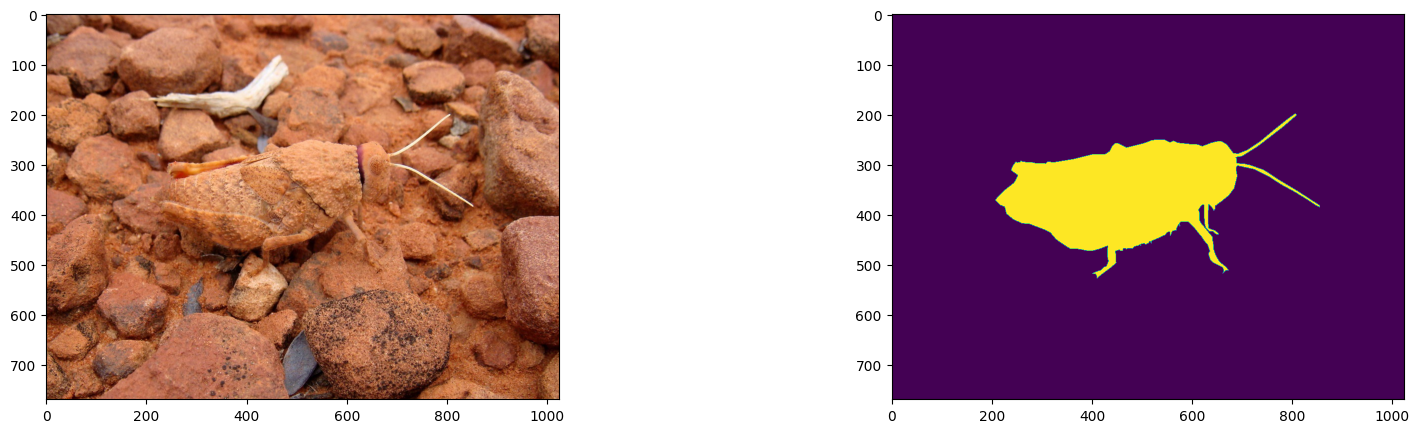

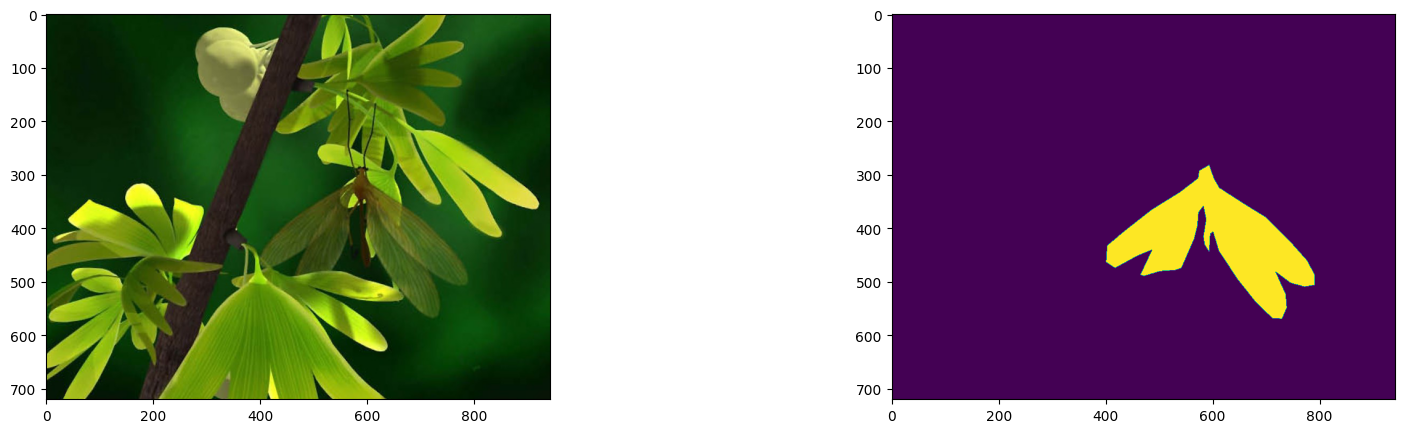

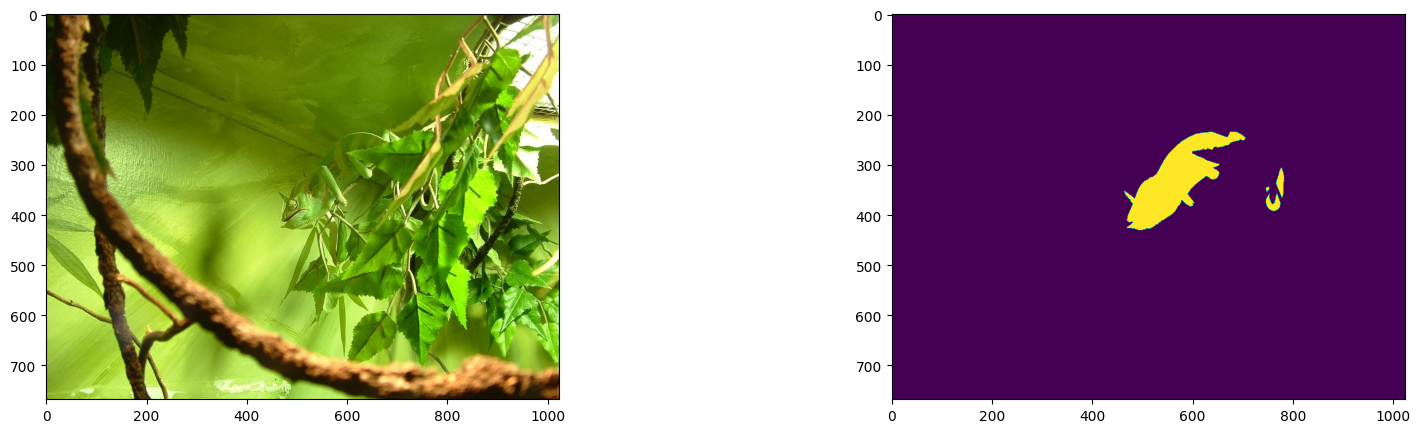

In [12]:
for i in range(5):
  _, axes = plt.subplots(1, 2, figsize=(20, 5))

  img=Image.open(train_set.imgs[i][0])
  mask=Image.open(train_set.imgs[i][1])

  axes[0].imshow(img)
  axes[1].imshow(mask)

  plt.show()

# ResNet BackBone

In [44]:
import torch.nn.functional as F

try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

model_urls = {'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth'}

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)





def _resnet(arch, block, layers, backbone_path, pretrained, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = torch.load(backbone_path)
        model.load_state_dict(state_dict)
        print("From {} Load {} Weights Succeed!".format(backbone_path, arch))
    return model


def resnet50(backbone_path, pretrained=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], backbone_path, pretrained, **kwargs)




# Positioning Module

applied on the highest-level features to locate the potential target objects

PM aims to harvest semantic-enhanced high-level features and further generate the initial segmentation map.

CHANNEL ATTENTION BLOCK:

In [14]:

class CA(nn.Module):
  def __init__(self,dim):
    super(CA, self).__init__()
    self.channel = dim
    self.gamma = nn.Parameter(torch.ones(1))
    self.softmax = nn.Softmax(dim=-1)


  def forward(self, x):

    #prendiamo i parametri di F: numero di channel, altezza e larghezza (numero di pixels)

    m_batchsize, C, height, width = x.size()

    #reshape F per ottenere the query, the key and the value:

    Q = x.view(m_batchsize, C, -1)
    K= x.view(m_batchsize, C, -1).permute(0, 2, 1) #trasposto perché ci serve così dopo
    V=x.view(m_batchsize, C, -1)
    #moltiplico Q per la trasposta di K
    energy = torch.bmm(Q, K)
    #apply a softmax layer to calculate the channel attention map

    attention_map=self.softmax(energy)

    out=torch.bmm(attention_map, V)
    #reshape of out
    out=out.view(m_batchsize, C, height, width)
    #The final feature F′ models the long-range semantic dependencies between the channels of feature maps and thus
    #is more discriminative than the input feature
    F_prime = self.gamma * out + x

    return F_prime


SPATIAL ATTENTION BLOCK

In [15]:

class SA(nn.Module):
  def __init__(self,dim):
    super(SA, self).__init__()
    self.channel = dim
    # We first employ three 1 × 1 convolution layers on the input features F′
    #and reshape the convolution results to generate three new feature maps Q′, K′, and V′

    self.Q_conv= nn.Conv2d(in_channels=dim, out_channels=dim//8, kernel_size=1)
    self.K_conv= nn.Conv2d(in_channels=dim, out_channels=dim//8, kernel_size=1)
    self.V_conv= nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=1)

    self.gamma = nn.Parameter(torch.ones(1))
    self.softmax = nn.Softmax(dim=-1)


  def forward(self, x):

    m_batchsize, C, height, width = x.size()

    Q = self.Q_conv(x).view(m_batchsize, -1, width * height).permute(0, 2, 1)
    K = self.K_conv(x).view(m_batchsize, -1, width * height)
    V = self.V_conv(x).view(m_batchsize, -1, width * height)

    energy = torch.bmm(Q, K)
    attention_map=self.softmax(energy)
    out = torch.bmm(V, attention_map.permute(0, 2, 1))
    out=out.view(m_batchsize, C, height, width)

    out = self.gamma * out + x

    return out




POSITIONING MODULE

In [16]:

class Positioning(nn.Module):
  def __init__(self,channel):
    super(Positioning, self).__init__()

    self.channel = channel

    self.cab=CA(self.channel)
    self.sab=SA(self.channel)
    #initial location map of the targets
    self.location_map=nn.Conv2d(in_channels=self.channel, out_channels=1, kernel_size=7,stride=1, padding=3)

  def forward(self, x):

    cab=self.cab(x)
    sab=self.sab(cab)
    map=self.location_map(sab)

    return sab, map



# Focus Module


CONTEXT EXPLORATION BLOCK

By such design, the CE block gains the capability of perceiving
rich contexts over a wide range of scales and thus could be
used for context reasoning and distraction discovery.

In [17]:
class CE(nn.Module):
  def __init__(self,channel):
    super(CE, self).__init__()
    self.in_channel=channel
    self.out_channel= int( channel/ 4)

    #channel reduction
    self.channel_reduction1=nn.Sequential(nn.Conv2d(in_channels=self.in_channel, out_channels=self.out_channel, kernel_size=1),
                             nn.BatchNorm2d(self.out_channel), nn.ReLU())
    self.channel_reduction2=nn.Sequential(nn.Conv2d(in_channels=self.in_channel, out_channels=self.out_channel, kernel_size=1),
                             nn.BatchNorm2d(self.out_channel), nn.ReLU())
    self.channel_reduction3=nn.Sequential(nn.Conv2d(in_channels=self.in_channel, out_channels=self.out_channel, kernel_size=1),
                             nn.BatchNorm2d(self.out_channel), nn.ReLU())
    self.channel_reduction4=nn.Sequential(nn.Conv2d(in_channels=self.in_channel, out_channels=self.out_channel, kernel_size=1),
                             nn.BatchNorm2d(self.out_channel), nn.ReLU())

     #convolution for local feature extraction

    self.fe1=nn.Sequential(nn.Conv2d(in_channels=self.out_channel, out_channels=self.out_channel, kernel_size=1, stride=1, padding=0),
                             nn.BatchNorm2d(self.out_channel), nn.ReLU())
    self.fe2=nn.Sequential(nn.Conv2d(in_channels=self.out_channel, out_channels=self.out_channel, kernel_size=3, stride=1, padding=1),
                             nn.BatchNorm2d(self.out_channel), nn.ReLU())
    self.fe3=nn.Sequential(nn.Conv2d(in_channels=self.out_channel, out_channels=self.out_channel, kernel_size=5, stride=1, padding=2),
                             nn.BatchNorm2d(self.out_channel), nn.ReLU())
    self.fe4=nn.Sequential(nn.Conv2d(in_channels=self.out_channel, out_channels=self.out_channel, kernel_size=7, stride=1, padding=3),
                             nn.BatchNorm2d(self.out_channel), nn.ReLU())

    #dilated convolution with a dilation rate of ri for context perceiving

    self.d1=nn.Sequential(nn.Conv2d(in_channels=self.out_channel, out_channels=self.out_channel, kernel_size=3,stride=1, padding=1, dilation=1),
                          nn.BatchNorm2d(self.out_channel), nn.ReLU())
    self.d2=nn.Sequential(nn.Conv2d(in_channels=self.out_channel, out_channels=self.out_channel, kernel_size=3,stride=1, padding=2, dilation=2),
                          nn.BatchNorm2d(self.out_channel), nn.ReLU())
    self.d3=nn.Sequential(nn.Conv2d(in_channels=self.out_channel, out_channels=self.out_channel, kernel_size=3,stride=1, padding=4, dilation=4),
                          nn.BatchNorm2d(self.out_channel), nn.ReLU())
    self.d4=nn.Sequential(nn.Conv2d(in_channels=self.out_channel, out_channels=self.out_channel, kernel_size=3,stride=1, padding=8, dilation=8),
                          nn.BatchNorm2d(self.out_channel), nn.ReLU())


    #. The outputs of all four branches are then concatenated and fused via a 3 × 3 convolution
    self.concatenation=nn.Sequential(nn.Conv2d(in_channels=self.in_channel, out_channels=self.in_channel, kernel_size=1),
                             nn.BatchNorm2d(self.in_channel), nn.ReLU())


  def forward(self, x):

      input1=self.channel_reduction1(x)
      feature_extraction1=self.fe1(input1)
      context_perceiving1= self.d1(feature_extraction1)

      input2=self.channel_reduction2(x) + context_perceiving1
      feature_extraction2=self.fe2(input2)
      context_perceiving2= self.d2(feature_extraction2)

      input3=self.channel_reduction3(x)+ context_perceiving2
      feature_extraction3=self.fe3(input3)
      context_perceiving3= self.d3(feature_extraction3)

      input4=self.channel_reduction1(x)+ context_perceiving3
      feature_extraction4=self.fe4(input4)
      context_perceiving4= self.d4(feature_extraction4)

      out= self.concatenation(torch.cat((context_perceiving1, context_perceiving2, context_perceiving3, context_perceiving4), 1))

      return out




FOCUS:

As the camouflaged objects typically share a similar appearance with the background, both false-positive and falsenegative predictions would naturally occur in the initial segmentation. The focus module (FM) is designed to first discover and then remove these false predictions. It takes the
current-level features derived from the backbone and the
higher-level prediction and features as the input, and outputs the refined features and a more accurate prediction

In [18]:
class focus(nn.Module):
  def __init__(self,channel1,channel2):
    super(focus, self).__init__()
    self.channel1=channel1
    self.channel2=channel2


    self.up = nn.Sequential(nn.Conv2d(self.channel2, self.channel1, 7, 1, 3),
                                nn.BatchNorm2d(self.channel1), nn.ReLU(), nn.UpsamplingBilinear2d(scale_factor=2))

    self.input_map=nn.Sequential(nn.UpsamplingBilinear2d(scale_factor=2),nn.Sigmoid())
    self.output_map = nn.Conv2d(self.channel1, 1, 7, 1, 3)

    self.fp = CE(self.channel1)
    self.fn = CE(self.channel1)

    #α and β are the learnable scale parameters which are initialized as 1
    self.alpha = nn.Parameter(torch.ones(1))
    self.beta = nn.Parameter(torch.ones(1))

    self.bn1 = nn.BatchNorm2d(self.channel1)
    self.relu1 = nn.ReLU()
    self.bn2 = nn.BatchNorm2d(self.channel1)
    self.relu2 = nn.ReLU()



  def forward(self, x, y, in_map):

      # x; current-level features
      # y: higher-level features
      # in_map: higher-level prediction

      #DISTRACTION DISCOVERY:

      # we first upsample the higher-level prediction and normalize it with a sigmoid layer

      up=self.up(y)
      N_map=self.input_map(in_map)

      # Then we use this normalized map and its reverse version to multiply the current-level feature
      #to generate the foreground-attentive features and the background-attentive features

      f_feature = x * N_map
      b_feature = x * (1 - N_map)

      #Finally,we feed these two types of features into two parallel context exploration
      #to perform contextual reasoning for discovering the false-positive distractions and
      #the false-negative distractions

      fp=self.fp(f_feature)
      fn=self.fn(b_feature)


      #DISTRACTION REMOVAL:


      #remove false predictions: suppress the ambiguous backgrounds
      refine1 = up - (self.alpha * fp)
      refine1 = self.bn1(refine1)
      refine1 = self.relu1(refine1)

      #add false error: missing foregrounds
      refine2 = refine1 + (self.beta * fn)
      refine2 = self.bn2(refine2)
      refine2 = self.relu2(refine2)

      #more accurate prediction map can be obtained
      #by applying a convolution layer on the refined feature

      output_map = self.output_map(refine2)

      return refine2, output_map



# NETWORK: PFnet

consists of two key modules,
i.e., the positioning module (PM) and the focus module (FM). The PM is designed to mimic the detection process
in predation for positioning the potential target objects from
a global perspective and the FM is then used to perform
the identification process in predation for refining the initial
segmentation results by focusing on the ambiguous regions.

In [19]:
import torchvision
import torch.nn.functional as F

class PFnet(nn.Module):
  def __init__(self,backbone_path=None):
    super(PFnet, self).__init__()


    # backbone
    #resnet50 = torchvision.models.resnet50(weights='DEFAULT')
    resnet = resnet50(backbone_path)
    self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
    self.layer1 = nn.Sequential(resnet.maxpool, resnet.layer1)
    self.layer2 = resnet.layer2
    self.layer3 = resnet.layer3
    self.layer4 = resnet.layer4

    # channel reduction
    self.cr4 = nn.Sequential(nn.Conv2d(2048, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU())
    self.cr3 = nn.Sequential(nn.Conv2d(1024, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU())
    self.cr2 = nn.Sequential(nn.Conv2d(512, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU())
    self.cr1 = nn.Sequential(nn.Conv2d(256, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU())

    # positioning
    self.positioning=Positioning(512)

    #focus
    self.focus3=focus(256,512)
    self.focus2=focus(128,256)
    self.focus1=focus(64,128)

    for m in self.modules():
      if isinstance(m, nn.ReLU):
        m.inplace = True



  def forward(self, x):

    layer0 = self.layer0(x)  # [-1, 64, h/2, w/2]
    layer1 = self.layer1(layer0)  # [-1, 256, h/4, w/4]
    layer2 = self.layer2(layer1)  # [-1, 512, h/8, w/8]
    layer3 = self.layer3(layer2)  # [-1, 1024, h/16, w/16]
    layer4 = self.layer4(layer3)  # [-1, 2048, h/32, w/32]


    # channel reduction
    cr4 = self.cr4(layer4)
    cr3 = self.cr3(layer3)
    cr2 = self.cr2(layer2)
    cr1 = self.cr1(layer1)



    # positioning
    positioning, predict4 = self.positioning(cr4)



    # focus
    focus3, predict3 = self.focus3(cr3, positioning, predict4)
    focus2, predict2 = self.focus2(cr2, focus3, predict3)
    focus1, predict1 = self.focus1(cr1, focus2, predict2)

    # rescale
    predict4 = F.interpolate(predict4, size=x.size()[2:], mode='bilinear', align_corners=True)
    predict3 = F.interpolate(predict3, size=x.size()[2:], mode='bilinear', align_corners=True)
    predict2 = F.interpolate(predict2, size=x.size()[2:], mode='bilinear', align_corners=True)
    predict1 = F.interpolate(predict1, size=x.size()[2:], mode='bilinear', align_corners=True)

    if self.training:
            return predict4, predict3, predict2, predict1

    return torch.sigmoid(predict4), torch.sigmoid(predict3), torch.sigmoid(predict2), torch.sigmoid(predict1)

# LOSS

In [20]:
class IOU_loss(nn.Module):
  def __init__(self):
    super(IOU_loss, self).__init__()

  def Iou(self,prediction,target):
    prediction = torch.sigmoid(prediction)
    #intersezione è la moltiplicazione perché prediction e target sono vettori tra zero e 1
    #gli unici valori che ci interessano sono quelli che per entrambi sono 1
    inter= (prediction * target).sum(dim=(2, 3))
    union = (prediction + target).sum(dim=(2, 3)) - inter
    iou = 1 - (inter / union)

    return iou.mean()

  def forward(self,prediction,target):
    return self.Iou(prediction,target)






In [21]:
class combined_loss(nn.Module):
  def __init__(self):
    super(combined_loss, self).__init__()


  def combined_loss(self,prediction,target):



    weight= 1 + 5 * torch.abs(F.avg_pool2d( target, kernel_size=31, stride=1, padding=15) - target)
    wbce = F.binary_cross_entropy_with_logits(prediction, target, reduce='none')
    wbce= (wbce**weight).sum(dim=(2, 3))// weight.sum(dim=(2, 3))

    inter= ((prediction * target)*weight).sum(dim=(2, 3))
    union = ((prediction + target)*weight).sum(dim=(2, 3)) - inter
    wiou = 1 - (inter / union)


    return (wbce+wiou).mean()

  def forward(self,prediction,target):
      return self.combined_loss(prediction,target)





In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Combined_loss=combined_loss().to(device)
bce_loss = nn.BCEWithLogitsLoss().to(device)
iou_loss=IOU_loss().to(device)


In [23]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def _sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Training

In [34]:
!pip install wandb -q

In [35]:
import wandb
wandb.login()
#769675e6de4fb7f4359c3fe17361006822a471b8

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [36]:
# WandB – Initialize a new run
wandb.init(project="Camouflaged Object Segmentation")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

# WandB – Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config          # Initialize config
config.batch_size = args['train_batch_size']          # input batch size for training (default: 64)
config.test_batch_size = 10    # input batch size for testing (default: 1000)
config.epochs = args['epoch_num']             # number of epochs to train (default: 10)
config.lr = args['lr']               # learning rate (default: 0.01)
config.momentum = args['momentum']        # SGD momentum (default: 0.5)
config.no_cuda = False         # disables CUDA training
config.seed = 42               # random seed (default: 42)
config.log_interval = 10     # how many batches to wait before logging training status

In [37]:

def test(args, model, device):
  model.eval()
  to_pil = transforms.ToPILImage()
  img_transform = transforms.Compose([
    transforms.Resize((args['scale'], args['scale'])),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
  Result=[]
  with torch.no_grad():

    image_path = os.path.join('/content/TestDataset/COD10K', 'Imgs')

    img_list = [os.path.splitext(f)[0] for f in os.listdir(image_path) if f.endswith('jpg')]
    for idx, img_name in enumerate(img_list):
        img = Image.open(os.path.join(image_path, img_name + '.jpg')).convert('RGB')

        w, h = img.size
        img_var = Variable(img_transform(img).unsqueeze(0)).to(device)

        _, _, _, prediction = model(img_var)


        prediction = np.array(transforms.Resize((h, w))(to_pil(prediction.data.squeeze(0).cpu())))

        Result.append(prediction)


  wandb.log({"Prediction": [wandb.Image(Image.fromarray(pred).convert('L'))
                              for pred in Result]})




In [38]:
import time
from tqdm import tqdm
from torch.autograd import Variable
import datetime



def train(net,optimizer):
   curr_iter = 1
   start_time = time.time()

   for epoch in range(args['last_epoch'] + 1, args['last_epoch'] + 1 + args['epoch_num']):
        loss_record, loss_1_record, loss_2_record, loss_3_record, loss_4_record = AvgMeter(), AvgMeter(), AvgMeter(), AvgMeter(), AvgMeter()

        train_iterator = tqdm(train_loader, total=len(train_loader))

        for data in train_iterator:

          if args['poly_train']:
                base_lr = args['lr'] * (1 - float(curr_iter) / float(total_epoch)) ** args['lr_decay']
                optimizer.param_groups[0]['lr'] = 2 * base_lr
                optimizer.param_groups[1]['lr'] = 1 * base_lr

          inputs, labels = data
          batch_size = inputs.size(0)

          inputs = Variable(inputs).to(device)
          labels = Variable(labels).to(device)

          optimizer.zero_grad()

          predict_1, predict_2, predict_3, predict_4 = net(inputs)

          #For the PM, we impose binary crossentropy (BCE) loss ℓbce and IoU loss ℓiou on its outputto guide the PM to explore the initial location of the target object

          bce = bce_loss(predict_1, labels)
          iou = iou_loss(predict_1, labels)

          loss_1= bce + iou

          #For the FM, we hope it could focus more on the distraction region.
          #Thus we combine the weighted BCE loss ℓwbce and weighted IoU loss ℓwiou , i.e.,
          #Lfm = ℓwbce + ℓwiou, to force the FM pay more attention to the possible distraction region

          loss_2 = Combined_loss(predict_2, labels)
          loss_3 = Combined_loss(predict_3, labels)
          loss_4 = Combined_loss(predict_4, labels)


          #overall loss
          ######################################
          ######### errore codice repo #########
          ######### fare test in merito ##########
          ######################################


          loss= loss_1  +  loss_2 + 2*loss_3  + 4*loss_4

          #loss= loss_1 + 4*loss_2 + 2*loss_3 + loss_4    #come c'è scritto nel paper  non penso cambi nulla ma boh

          loss.backward()
          optimizer.step()

          loss_record.update(loss.data, batch_size)
          loss_1_record.update(loss_1.data, batch_size)
          loss_2_record.update(loss_2.data, batch_size)
          loss_3_record.update(loss_3.data, batch_size)
          loss_4_record.update(loss_4.data, batch_size)


          curr_iter += 1


        if (epoch % 5)==0: test(args, net, device)
        wandb.log({"Total Loss": loss })

        if epoch in args['save_point']:
            net.cpu()
            torch.save(net.state_dict(), os.path.join('/content/drive/MyDrive', '%d.pth' % epoch))
            torch.save(net.state_dict(), "model.h5")
            wandb.save('model.h5')

            net.to(device)

        if epoch >= args['epoch_num']:
            net.cpu()
            torch.save(net.state_dict(), os.path.join('/content/drive/MyDrive', '%d.pth' % epoch))
            torch.save(net.state_dict(), "model.h5")
            wandb.save('model.h5')


            print("Total Training Time: {}".format(str(datetime.timedelta(seconds=int(time.time() - start_time)))))
            print('PFNet')
            print("Optimization Have Done!")
            return













MAIN

In [45]:
print(args)
print('PFNet')


net =  PFnet('/content/drive/MyDrive/resnet50-19c8e357.pth').to(device).train()

if args['optimizer'] == 'Adam':
        print("Adam")
        optimizer = optim.Adam([
            {'params': [param for name, param in net.named_parameters() if name[-4:] == 'bias'],
             'lr': 2 * args['lr']},
            {'params': [param for name, param in net.named_parameters() if name[-4:] != 'bias'],
             'lr': 1 * args['lr'], 'weight_decay': args['weight_decay']}
        ])
else:
  print("SGD")
  optimizer = optim.SGD([
            {'params': [param for name, param in net.named_parameters() if name[-4:] == 'bias'],
             'lr': 2 * args['lr']},
            {'params': [param for name, param in net.named_parameters() if name[-4:] != 'bias'],
             'lr': 1 * args['lr'], 'weight_decay': args['weight_decay']}
        ], momentum=args['momentum'])

if len(args['snapshot']) > 0:
        print('Training Resumes From \'%s\'' % args['snapshot'])
        net.load_state_dict(torch.load(os.path.join('/content/drive/MyDrive', args['snapshot'] + '.pth')))
        total_epoch = (args['epoch_num'] - int(args['snapshot'])) * len(train_loader)
        print(total_epoch)

#net = nn.DataParallel(net, device_ids=torch.device('cuda', 0))




{'epoch_num': 45, 'train_batch_size': 16, 'last_epoch': 0, 'lr': 0.001, 'lr_decay': 0.9, 'weight_decay': 0.0005, 'momentum': 0.9, 'snapshot': '', 'scale': 416, 'save_point': [1, 10, 20, 30, 40], 'poly_train': True, 'optimizer': 'SGD'}
PFNet
From /content/drive/MyDrive/resnet50-19c8e357.pth Load resnet50 Weights Succeed!
SGD


In [ ]:
wandb.watch(net, log="all")
train(net, optimizer)
wandb.finish()

  0%|          | 0/253 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
<ipython-input-21-888ac2be938d>:12: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  wbce= (wbce**weight).sum(dim=(2, 3))// weight.sum(dim=(2, 3))
 12%|█▏        | 31/253 [00:51<03:51,  1.04s/it]

# Testing

In [ ]:
model = PFnet().to(device)
model.load_state_dict(torch.load(os.path.join('/content/drive/MyDrive', '10' + '.pth')))


In [ ]:
model.eval()
to_pil = transforms.ToPILImage()
img_transform = transforms.Compose([
    transforms.Resize((args['scale'], args['scale'])),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

with torch.no_grad():

   image_path = os.path.join('/content/TestDataset/COD10K', 'Imgs')

   img_list = [os.path.splitext(f)[0] for f in os.listdir(image_path) if f.endswith('jpg')]
   for idx, img_name in enumerate(img_list):
      img = Image.open(os.path.join(image_path, img_name + '.jpg')).convert('RGB')

      w, h = img.size
      img_var = Variable(img_transform(img).unsqueeze(0)).to(device)

      _, _, _, prediction = model(img_var)


      prediction = np.array(transforms.Resize((h, w))(to_pil(prediction.data.squeeze(0).cpu())))



      Image.fromarray(prediction).convert('L').save(os.path.join("/content/drive/MyDrive/Result", "COD10K", img_name + '.png'))


In [ ]:
image_path = os.path.join("/content/drive/MyDrive/Result", "COD10K")
prediction_list = [os.path.splitext(f)[0] for f in os.listdir(image_path) if f.endswith('png')]


test_set = ImageFolder('/content/TestDataset/COD10K', joint_transform, img_transform, target_transform)
print("Test set: {}".format(test_set.__len__()))

In [ ]:
for i in range(5):
  _, axes = plt.subplots(1,2, figsize=(20, 5))

  test=Image.open(test_set.imgs[i][0])
  result=Image.open(os.path.join(image_path, prediction_list[i]  + '.png')).convert('RGB')

  axes[0].imshow(result)
  axes[1].imshow(test)


  plt.show()